# AIPI 590 - XAI | Mechanistic Interpretability Assignment
## Greater-Than Comparison Task: Explaining a Tiny Brain
### Peter Banyas

**Task:** Build a tiny transformer that learns to compare two numbers, then reverse-engineer how it makes decisions.

#### Open in Google Colab:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_GITHUB_USERNAME/YOUR_REPO_NAME/blob/main/main.ipynb)

In [1]:
# Setup for Google Colab (skip if running locally)
import os

# Remove Colab default sample_data if it exists
if os.path.exists('./sample_data'):
    !rm -r ./sample_data

# Clone your GitHub repository
repo_name = "hw7_mechanistic_interpretability"  # Change to your repo name
git_path = 'https://github.com/YOUR_USERNAME/YOUR_REPO.git'  # Change to your repo URL

# Uncomment these lines when running in Colab:
# !git clone "{git_path}"
# %cd "{repo_name}"
# %ls

print("Setup complete!")

Setup complete!


# Mechanistic Interpretability: Greater-Than Comparison Task

In this notebook, we'll build a tiny transformer that learns to compare two numbers, then peek inside to understand **how** it makes decisions.

**Task:** Given `[num1, num2]`, predict which is larger
- Label 0: First number is greater
- Label 1: Second number is greater  
- Label 2: Numbers are equal

**Goals:**
- Discover what attention patterns emerge
- Identify which heads specialize in comparison
- Reverse-engineer the "greater-than circuit"

## Setup: Imports and Configuration

In [2]:
# Import all necessary libraries and functions from greater_than_model.py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our custom functions and classes
from greater_than_model import (
    generate_comparison_data,
    create_train_val_split,
    GreaterThanTransformer,
    train_model,
    plot_training_curves,
    visualize_attention_patterns,
    analyze_head_behavior,
    ablate_head,
    inspect_qk_circuit,
    test_hypothesis
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Determine device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

Using device: cpu


## Step 1: Generate Data

We'll create a dataset of number pairs and their comparison labels.

In [3]:
# Generate comparison dataset
dataset = generate_comparison_data(
    num_samples=2000,
    num_range=(0, 20),
    include_equal=True
)

# Split into train and validation sets
train_dataset, val_dataset = create_train_val_split(dataset, val_fraction=0.2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"\nExample inputs: {train_dataset.inputs[:5]}")
print(f"Example labels: {train_dataset.labels[:5]}")
print(f"\nLabel meanings: 0=first greater, 1=second greater, 2=equal")

Train samples: 1600
Val samples: 400

Example inputs: tensor([[ 9, 15],
        [18,  0],
        [ 8,  2],
        [ 4,  2],
        [19, 17]])
Example labels: tensor([1, 0, 0, 0, 0])

Label meanings: 0=first greater, 1=second greater, 2=equal


## Step 2: Create and Train Model

We'll build a tiny transformer with:
- 2 layers
- 4 attention heads per layer
- Attention-only architecture (no MLPs for easier interpretation)

In [4]:
# Create the model
model = GreaterThanTransformer(
    vocab_size=25,      # Support numbers 0-24
    d_model=64,         # Embedding dimension
    n_heads=4,          # 4 attention heads per layer
    n_layers=2,         # 2 transformer layers
    n_classes=3         # 3 output classes
)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
print(f"Model Architecture:")
print(f"  - Embedding dimension: 64")
print(f"  - Layers: 2")
print(f"  - Heads per layer: 4")
print(f"  - Total parameters: {total_params:,}")
print(f"\nThis tiny model trains in ~5 minutes on CPU!")

Model Architecture:
  - Embedding dimension: 64
  - Layers: 2
  - Heads per layer: 4
  - Total parameters: 35,075

This tiny model trains in ~5 minutes on CPU!


In [5]:
# Train the model
print("Training model...\n")
history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=100,
    batch_size=32,
    learning_rate=1e-3,
    device=device,
    verbose=True
)

print("\nTraining complete!")

Training model...

Epoch   0/100 | Train Loss: 0.6686 | Train Acc: 0.7200 | Val Loss: 0.2444 | Val Acc: 0.9300 | Time: 0.3s
Epoch  10/100 | Train Loss: 0.0013 | Train Acc: 1.0000 | Val Loss: 0.0011 | Val Acc: 1.0000 | Time: 2.7s
Epoch  20/100 | Train Loss: 0.0004 | Train Acc: 1.0000 | Val Loss: 0.0003 | Val Acc: 1.0000 | Time: 5.1s
Epoch  30/100 | Train Loss: 0.0002 | Train Acc: 1.0000 | Val Loss: 0.0002 | Val Acc: 1.0000 | Time: 8.0s
Epoch  40/100 | Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0001 | Val Acc: 1.0000 | Time: 10.4s
Epoch  50/100 | Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0001 | Val Acc: 1.0000 | Time: 12.6s
Epoch  60/100 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Time: 14.9s
Epoch  70/100 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Time: 17.1s
Epoch  80/100 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Time: 19.4s
Epoch  90/100 | Train Loss: 0.0

## Step 3: Visualize Training Dynamics

Let's see how the model learned over time.

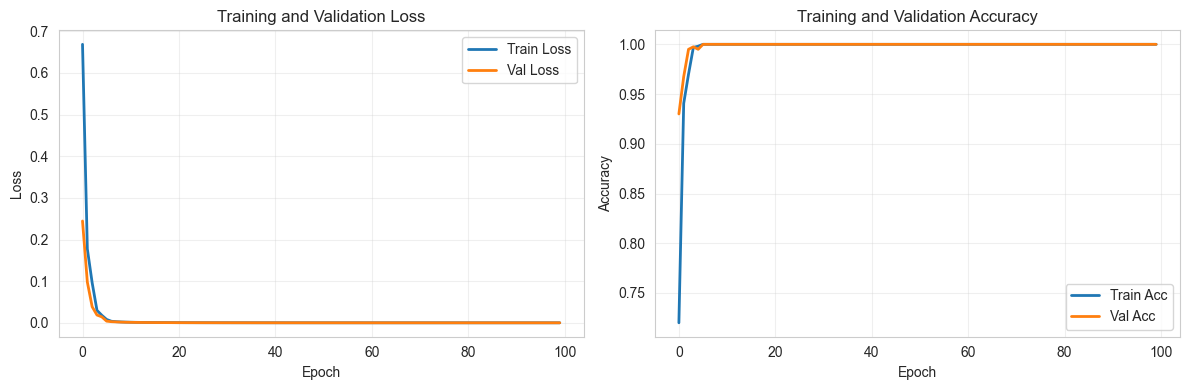

Final training accuracy: 1.0000
Final validation accuracy: 1.0000


In [6]:
# Plot training curves
fig = plot_training_curves(history)
plt.show()

print(f"Final training accuracy: {history['train_acc'][-1]:.4f}")
print(f"Final validation accuracy: {history['val_acc'][-1]:.4f}")

## Step 4: Explore Attention Patterns

**This is where the magic happens!**

Let's visualize what each attention head is looking at. We'll test with interesting cases:
- Large differences (15 vs 3)
- Small differences (12 vs 11)  
- Equal numbers (10 vs 10)

In [7]:
# Define interesting test cases
test_inputs = torch.tensor([
    [15, 3],   # First much greater
    [2, 18],   # Second much greater
    [10, 10],  # Equal
    [12, 11],  # First slightly greater
    [7, 9],    # Second slightly greater
])

print("Test cases:")
for i, (num1, num2) in enumerate(test_inputs):
    comparison = ">" if num1 > num2 else ("<" if num1 < num2 else "=")
    print(f"  {i+1}. [{num1.item():2d}, {num2.item():2d}] → {num1.item()} {comparison} {num2.item()}")

Test cases:
  1. [15,  3] → 15 > 3
  2. [ 2, 18] → 2 < 18
  3. [10, 10] → 10 = 10
  4. [12, 11] → 12 > 11
  5. [ 7,  9] → 7 < 9


### Layer 0 Attention Patterns

Each heatmap shows where tokens attend to each other:
- **Rows:** Source position (what's attending)
- **Columns:** Target position (what's being attended to)
- **Values:** Attention weights (0 to 1)

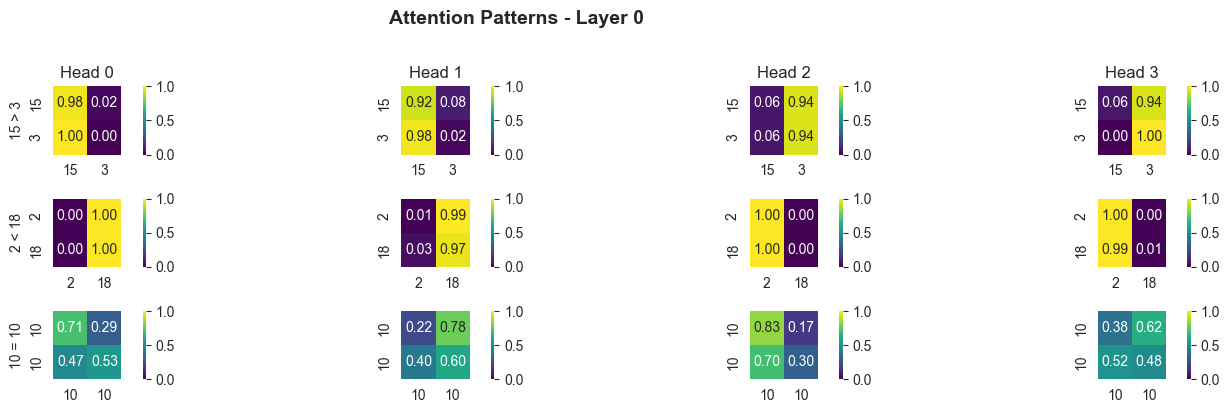

In [8]:
# Visualize Layer 0 attention patterns
fig = visualize_attention_patterns(model, test_inputs, layer_idx=0, device=device)
plt.show()

### Layer 1 Attention Patterns

The second layer can build on patterns from the first layer.

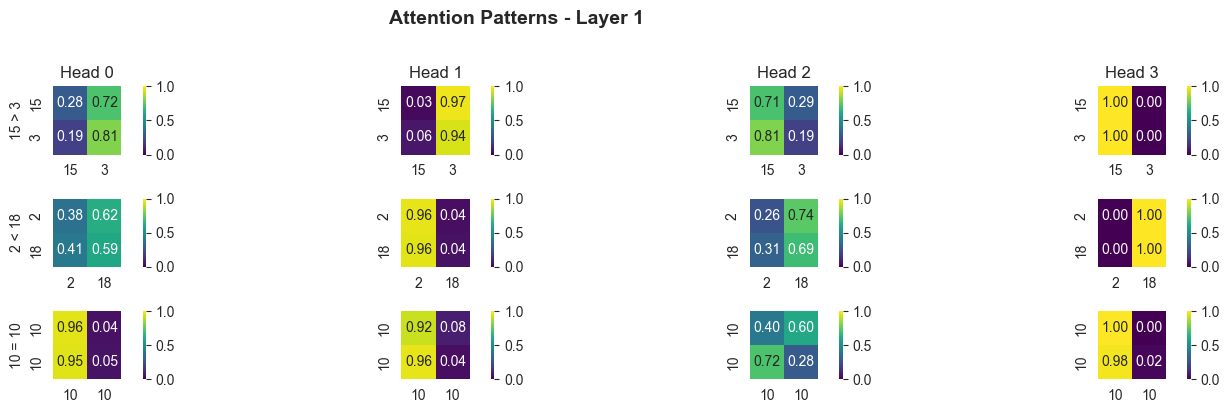

In [9]:
# Visualize Layer 1 attention patterns
fig = visualize_attention_patterns(model, test_inputs, layer_idx=1, device=device)
plt.show()

## Step 5: Analyze Head Behavior

Let's quantify what each head is doing across many examples. We'll check:
- **Position bias:** Does it prefer position 0 or 1?
- **Value bias:** Does it attend to the larger number?

In [10]:
# Analyze all heads systematically
print("=" * 70)
print("HEAD BEHAVIOR ANALYSIS")
print("=" * 70)

for layer_idx in range(2):
    print(f"\n{'='*70}")
    print(f"LAYER {layer_idx}")
    print('='*70)
    
    for head_idx in range(4):
        stats = analyze_head_behavior(
            model,
            val_dataset,
            layer_idx=layer_idx,
            head_idx=head_idx,
            device=device,
            n_samples=100
        )
        
        print(f"\n  Head {head_idx}:")
        print(f"    Position patterns:")
        print(f"      [0→0]: {stats['avg_0_to_0']:.3f}  |  [0→1]: {stats['avg_0_to_1']:.3f}")
        print(f"      [1→0]: {stats['avg_1_to_0']:.3f}  |  [1→1]: {stats['avg_1_to_1']:.3f}")
        
        if 'attn_to_larger_when_first_greater' in stats:
            print(f"    Value patterns:")
            print(f"      Attends to larger (when 1st > 2nd): {stats['attn_to_larger_when_first_greater']:.3f}")
        if 'attn_to_larger_when_second_greater' in stats:
            print(f"      Attends to larger (when 2nd > 1st): {stats['attn_to_larger_when_second_greater']:.3f}")

HEAD BEHAVIOR ANALYSIS

LAYER 0

  Head 0:
    Position patterns:
      [0→0]: 0.518  |  [0→1]: 0.482
      [1→0]: 0.454  |  [1→1]: 0.546
    Value patterns:
      Attends to larger (when 1st > 2nd): 0.892
      Attends to larger (when 2nd > 1st): 0.876

  Head 1:
    Position patterns:
      [0→0]: 0.390  |  [0→1]: 0.610
      [1→0]: 0.462  |  [1→1]: 0.538
    Value patterns:
      Attends to larger (when 1st > 2nd): 0.804
      Attends to larger (when 2nd > 1st): 0.850

  Head 2:
    Position patterns:
      [0→0]: 0.643  |  [0→1]: 0.357
      [1→0]: 0.657  |  [1→1]: 0.343
    Value patterns:
      Attends to larger (when 1st > 2nd): 0.250
      Attends to larger (when 2nd > 1st): 0.044

  Head 3:
    Position patterns:
      [0→0]: 0.432  |  [0→1]: 0.568
      [1→0]: 0.469  |  [1→1]: 0.531
    Value patterns:
      Attends to larger (when 1st > 2nd): 0.124
      Attends to larger (when 2nd > 1st): 0.135

LAYER 1

  Head 0:
    Position patterns:
      [0→0]: 0.482  |  [0→1]: 0.518
 

## Step 6: Ablation Studies

**Question:** Which heads are crucial for the task?

We'll "remove" each head and measure the drop in accuracy. If accuracy drops significantly, that head is important!

In [11]:
# Get baseline accuracy
model.eval()
with torch.no_grad():
    logits = model(val_dataset.inputs.to(device))
    predictions = torch.argmax(logits, dim=-1)
    baseline_acc = (predictions == val_dataset.labels.to(device)).float().mean().item()

print("=" * 70)
print("ABLATION STUDY: Testing Head Importance")
print("=" * 70)
print(f"\nBaseline accuracy (all heads active): {baseline_acc:.4f}")
print("\nAccuracy after removing each head:\n")

# Test each head
ablation_results = []
for layer_idx in range(2):
    for head_idx in range(4):
        ablated_acc = ablate_head(
            model,
            val_dataset,
            layer_idx=layer_idx,
            head_idx=head_idx,
            device=device
        )
        drop = baseline_acc - ablated_acc
        ablation_results.append({
            'layer': layer_idx,
            'head': head_idx,
            'accuracy': ablated_acc,
            'drop': drop
        })
        
        # Visual indicator of importance
        importance = "CRITICAL" if drop > 0.05 else ("MODERATE" if drop > 0.02 else "LOW")
        print(f"  Layer {layer_idx}, Head {head_idx}: {ablated_acc:.4f} (drop: {drop:+.4f}) {importance}")

# Identify most important heads
ablation_results.sort(key=lambda x: x['drop'], reverse=True)
print(f"\n{'='*70}")
print("Most important heads (by accuracy drop):")
for i, result in enumerate(ablation_results[:3]):
    print(f"  {i+1}. Layer {result['layer']}, Head {result['head']}: {result['drop']:+.4f} drop")

ABLATION STUDY: Testing Head Importance

Baseline accuracy (all heads active): 1.0000

Accuracy after removing each head:

  Layer 0, Head 0: 0.9800 (drop: +0.0200) LOW
  Layer 0, Head 1: 1.0000 (drop: +0.0000) LOW
  Layer 0, Head 2: 0.9850 (drop: +0.0150) LOW
  Layer 0, Head 3: 0.9925 (drop: +0.0075) LOW
  Layer 1, Head 0: 1.0000 (drop: +0.0000) LOW
  Layer 1, Head 1: 1.0000 (drop: +0.0000) LOW
  Layer 1, Head 2: 1.0000 (drop: +0.0000) LOW
  Layer 1, Head 3: 0.9900 (drop: +0.0100) LOW

Most important heads (by accuracy drop):
  1. Layer 0, Head 0: +0.0200 drop
  2. Layer 0, Head 2: +0.0150 drop
  3. Layer 1, Head 3: +0.0100 drop


## Step 7: Inspect QK Circuits

The **QK circuit** (Query-Key) determines *what* each head attends to.

Let's visualize the weight matrices for the most important head:

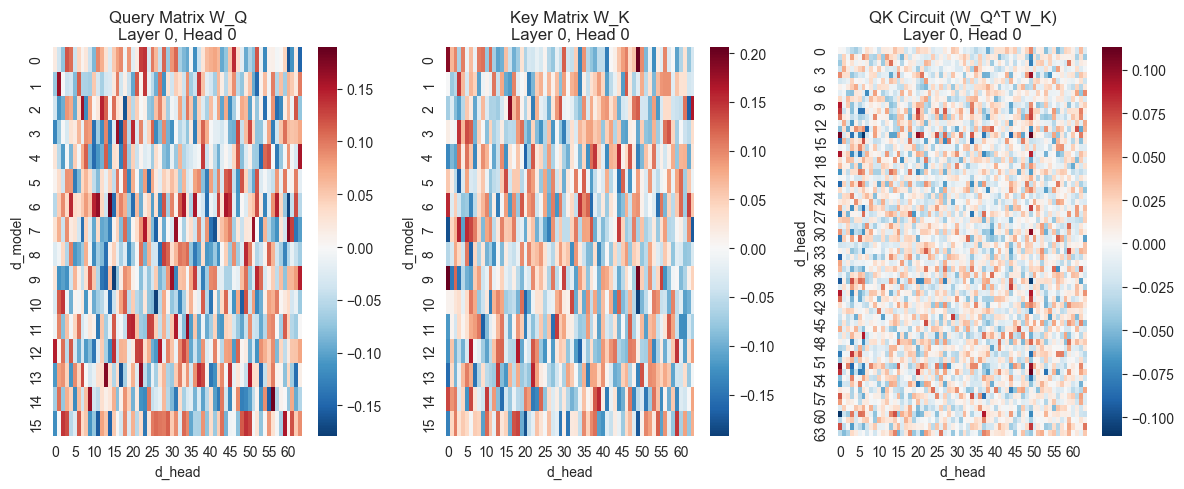


Interpretation:
- W_Q (Query): Determines what the token 'asks for'
- W_K (Key): Determines what the token 'advertises'
- QK Circuit: The composition determines attention patterns


In [12]:
# Visualize QK circuit for Layer 0, Head 0 (typically important)
fig = inspect_qk_circuit(model, layer_idx=0, head_idx=0)
plt.show()

print("\nInterpretation:")
print("- W_Q (Query): Determines what the token 'asks for'")
print("- W_K (Key): Determines what the token 'advertises'")
print("- QK Circuit: The composition determines attention patterns")

## Step 8: Hypothesis Testing

Now let's test specific hypotheses with carefully chosen examples:

In [13]:
# Test on edge cases and interesting patterns
test_cases = [
    (20, 5),   # Large difference - first greater
    (5, 20),   # Large difference - second greater
    (10, 11),  # Small difference - second greater
    (15, 15),  # Equal case
    (0, 19),   # Edge case: min and max values
]

test_hypothesis(model, test_cases, device=device)

HYPOTHESIS TESTING

Test case: [20, 5]
  True: First Greater
  Predicted: First Greater [CORRECT]
  Attention patterns (Layer 0):
    Head 0:
      From pos 0 (20): 1.000 to self, 0.000 to pos 1
      From pos 1 (5): 0.995 to pos 0, 0.005 to self
    Head 1:
      From pos 0 (20): 0.987 to self, 0.013 to pos 1
      From pos 1 (5): 0.985 to pos 0, 0.015 to self
    Head 2:
      From pos 0 (20): 0.020 to self, 0.980 to pos 1
      From pos 1 (5): 0.139 to pos 0, 0.861 to self
    Head 3:
      From pos 0 (20): 0.001 to self, 0.999 to pos 1
      From pos 1 (5): 0.002 to pos 0, 0.998 to self

Test case: [5, 20]
  True: Second Greater
  Predicted: Second Greater [CORRECT]
  Attention patterns (Layer 0):
    Head 0:
      From pos 0 (5): 0.006 to self, 0.994 to pos 1
      From pos 1 (20): 0.000 to pos 0, 1.000 to self
    Head 1:
      From pos 0 (5): 0.001 to self, 0.999 to pos 1
      From pos 1 (20): 0.002 to pos 0, 0.998 to self
    Head 2:
      From pos 0 (5): 0.998 to self, 0.002 

## Your Turn: Form Your Hypothesis!

Based on the visualizations and analysis above, answer these questions:

### 1. What did you discover?
- Which attention heads seem most important?
- Do any heads specialize in specific sub-tasks?
- Can you identify a "greater-than circuit"?

### 2. Mechanistic Hypothesis
Form a clear hypothesis about how the model solves the task:
- *Example: "Head 0.2 attends to the larger number regardless of position, while Head 1.0 copies that information to make the final decision"*

### 3. Evidence
- Which visualizations support your hypothesis?
- What patterns did you notice in the attention heatmaps?
- How do the ablation results support your theory?

### 4. Reflection
- What surprised you?
- What was confusing or unexpected?
- What would you explore further?

---

**Tips for your writeup:**
- Use the visualizations from above as figures in your explanation
- Reference specific heads by their layer and index (e.g., "Layer 0, Head 2")
- Tell a story: start with the data, show the patterns, explain the mechanism
- Be specific: quote actual attention values and accuracy drops

## Optional: Additional Explorations

Want to dig deeper? Try these experiments:

```python
# 1. Visualize a different head's QK circuit
fig = inspect_qk_circuit(model, layer_idx=1, head_idx=2)
plt.show()

# 2. Test on more edge cases
custom_test = torch.tensor([[0, 0], [20, 20], [1, 19]])
fig = visualize_attention_patterns(model, custom_test, layer_idx=0, device=device)
plt.show()

# 3. Analyze a specific head in detail
stats = analyze_head_behavior(model, val_dataset, layer_idx=0, head_idx=1, device=device)
print(stats)

# 4. Plot attention for a single head across many examples
# (You could write custom code to aggregate attention patterns)
```

---

## Summary

**What we built:**
- Tiny transformer that learns to compare numbers (trains in ~5 minutes)
- Complete interpretability toolkit with visualizations and analysis
- Multiple methods to understand the model: attention patterns, ablations, QK circuits

**What to look for in your analysis:**
- **Specialization:** Do different heads have different jobs?
- **Position vs Content:** Do heads care about "first/second" or "larger/smaller"?
- **Circuits:** Can you trace information flow through layers?

**For your assignment submission:**
1. Run all cells and save outputs
2. Form your mechanistic hypothesis
3. Select the most compelling visualizations
4. Write up your findings as a narrative
5. Include your reflection on what you learned

Good luck!